## 데이터 생성
* 기본: 23년 9월 ~ 24년 9월
* 추가: 23년 5월 ~ 23년 9월

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 상수 정의
NUM_USERS = 100000
NUM_PURCHASES = 300000
ORIGINAL_START_DATE = datetime(2023, 9, 14)  # 기존 시작일
END_DATE = datetime(2024, 9, 26)  # 기존 종료일
NEW_START_DATE = datetime(2023, 5, 1)  # 새로운 시작일

In [3]:
# 추가 기간 비율 계산
additional_days = (ORIGINAL_START_DATE - NEW_START_DATE).days
original_period_days = (END_DATE - ORIGINAL_START_DATE).days
additional_period_ratio = additional_days / original_period_days
# 추가 구매 수 계산
ADDITIONAL_PURCHASES = int(NUM_PURCHASES * additional_period_ratio)

In [4]:
# 아이템 정의
items = {
    "Gear Pass": ["play supporting item", 9800],
    "Joker Club": ["play supporting item", 29700],
    "2nd Ultimate Pass": ["play supporting item", 19800],
    "Costume": ["play support + cosmetic item", 14900],
    "Hair": ["cosmetic item", 8900],
    "Accessory": ["cosmetic item", 50000]
}

In [5]:
# 유저 세그멘테이션 및 구매 패턴 정의
segments = {
    "necessary": {
        "items": ["Gear Pass", "2nd Ultimate Pass", "Joker Club"],
        "probs": [0.60, 0.30, 0.10],  # 필수 아이템에 집중
        "purchase_frequency": 1.0,    # 기본 구매 빈도
        "avg_purchases": 3            # 유저당 평균 구매 횟수
    },
    "cosmetic": {
        "items": ["Costume", "Hair", "Accessory", "Gear Pass"],
        "probs": [0.35, 0.30, 0.30, 0.05],  # 코스메틱 아이템에 집중
        "purchase_frequency": 1.5,    # necessary보다 50% 더 많은 구매
        "avg_purchases": 5            # 유저당 평균 구매 횟수
    },
    "balanced": {
        "items": list(items.keys()),
        "probs": [0.20, 0.15, 0.15, 0.20, 0.15, 0.15],  # 골고루 구매
        "purchase_frequency": 2.0,    # necessary보다 2배 많은 구매
        "avg_purchases": 8            # 유저당 평균 구매 횟수
    }
}

In [6]:
# 유저 세그먼트 할당 (균등 분포)
np.random.seed(42)
user_segments = np.random.choice(
    list(segments.keys()),
    NUM_USERS,
    p=[0.33, 0.33, 0.34]  # 세 그룹이 거의 균등하게 분포
)
user_ids = np.arange(1, NUM_USERS + 1)
user_data = dict(zip(user_ids, user_segments))

In [7]:
# 월별 매출 조정 요소 정의 (기존 + 새로운 기간)
monthly_adjustments = {
    # 새로운 기간 추가
    (2023, 5): {"Accessory": 0.68, "Joker Club": 0.9, "Gear Pass": 0.73, "Costume":0.75, "2nd Ultimate Pass":0.74, "Hair":0.73},
    (2023, 6): {"Accessory": 1.3, "Joker Club": 0.45, "Gear Pass": 0.54, "Costume":0.63, "2nd Ultimate Pass":0.63, "Hair":0.62},  # 6월 매출
    (2023, 7): {"Accessory": 1.15, "Joker Club": 0.55, "Gear Pass": 0.7, "Costume":0.54, "2nd Ultimate Pass":0.66, "Hair":0.62},               # 7월 매출
    (2023, 8): {"Accessory": 1.1, "Joker Club": 0.79, "Gear Pass": 0.7, "Costume":0.57, "2nd Ultimate Pass":0.64, "Hair":0.6},              # 8월 매출
    # 기존 기간 (변경 없음)
    (2023, 9): {"Accessory": 1.1, "all": 1.0 },               # 9월 매출 정상
    (2023, 10): {"Accessory": 1.2, "all": 1.0},              # 10월 매출 정상
    (2023, 11): {"all": 1.0},                                # 11월 매출 정상
    (2023, 12): {"all": 0.5},                                # 12월 매출 감소 50%
    # 2024 (기존 설정 유지)
    (2024, 1): {"all": 0.7},                                 # 1월 매출 감소 30%
    (2024, 2): {"all": 1.0},                                 # 2월 매출 정상화
    (2024, 3): {"Accessory": 1.1, "all": 1.0},               # 3월 Accessory 매출 10% 증가
    (2024, 4): {"Accessory": 1.3, "all": 1.7},               # 4월 Accessory 20% 증가, 나머지 50% 증가
    (2024, 5): {"all": 1.15},                                # 5월 매출 13% 증가
    (2024, 6): {"all": 1.1},                                 # 6월 매출 정상화
    (2024, 7): {"all": 1.3, "Gear Pass":1.4, "Joker Club":1.5}, # 7월 매출 정상화
    (2024, 8): {"Accessory": 0.05, "Joker Club": 1.2, "Gear Pass": 1.2, "Costume":0.8, "2nd Ultimate Pass":1.0, "Hair":0.9}, # 8월 Accessory 매출 30% 감소
    (2024, 9): {"Accessory": 0.3, "all": 1.0, "Joker Club": 1.2}  # 9월 Accessory 매출 40% 감소
}

In [8]:
# 세그먼트 패턴 기반 구매 데이터 생성
data = []

In [9]:
# 유저당 예상 구매 횟수 계산
total_expected_purchases = sum(segments[segment]["avg_purchases"] for segment in segments.keys()) * NUM_USERS / 3

In [10]:
# NUM_PURCHASES에 맞추기 위한 스케일링 팩터
scaling_factor = NUM_PURCHASES / total_expected_purchases

In [11]:
# 구매 데이터 생성 함수
def generate_purchase_data(start_date, end_date, num_purchases_target, random_seed=42):
    """
    주어진 기간에 대한 구매 데이터를 생성하는 함수

    Parameters:
    - start_date: 시작 날짜
    - end_date: 종료 날짜
    - num_purchases_target: 목표 구매 수
    - random_seed: 랜덤 시드

    Returns:
    - 생성된 구매 데이터 리스트
    """
    np.random.seed(random_seed)  # 랜덤 시드 설정
    data = []

    # 유저당 예상 구매 횟수 계산
    total_expected_purchases = sum(segments[segment]["avg_purchases"] for segment in segments.keys()) * NUM_USERS / 3

    # 목표 구매 수에 맞추기 위한 스케일링 팩터
    scaling_factor = num_purchases_target / total_expected_purchases

    for user_id in user_ids:
        segment = user_data[user_id]
        segment_info = segments[segment]

        # 유저별 구매 횟수 결정 (확률적 변동 포함)
        avg_purchases = segment_info["avg_purchases"]
        # 포아송 분포로 현실적인 구매 횟수 생성
        num_user_purchases = max(1, np.random.poisson(avg_purchases * scaling_factor))

        for _ in range(num_user_purchases):
            # 세그먼트 확률에 따라 아이템 선택
            item = np.random.choice(segment_info["items"], p=segment_info["probs"])
            item_name, price = items[item]

            # 구매 날짜 생성
            purchase_date = start_date + timedelta(days=np.random.randint((end_date - start_date).days))

            # 월별 조정 적용
            year = purchase_date.year
            month = purchase_date.month

            # 조정 계수 가져오기
            adjustment = 1.0
            if (year, month) in monthly_adjustments:
                if item in monthly_adjustments[(year, month)]:
                    adjustment = monthly_adjustments[(year, month)][item]
                else:
                    adjustment = monthly_adjustments[(year, month)]["all"]

            # 매출 감소 처리 (확률적으로 구매 건너뛰기)
            if adjustment < 1.0:
                if np.random.rand() > adjustment:
                    continue

            # 구매 데이터 추가
            data.append([user_id, purchase_date, item, item_name, price])

            # 매출 증가 처리 (추가 구매 생성)
            if adjustment > 1.0:
                duplicate_prob = adjustment - 1.0
                while np.random.rand() < duplicate_prob:
                    # 약간 다른 날짜로 추가 구매 생성
                    duplicate_date = purchase_date + timedelta(days=np.random.randint(1, 7))
                    if duplicate_date <= end_date:  # 종료일을 넘지 않도록
                        data.append([user_id, duplicate_date, item, item_name, price])
                    duplicate_prob -= 1.0  # 추가 중복 구매 확률 감소

    return data

In [12]:
# 기존 데이터 생성 (9/14/2023 ~ 9/26/2024)
original_data = generate_purchase_data(ORIGINAL_START_DATE, END_DATE, NUM_PURCHASES, random_seed=42)

# 새로운 데이터 생성 (6/1/2023 ~ 9/13/2023)
additional_data = generate_purchase_data(NEW_START_DATE, ORIGINAL_START_DATE - timedelta(days=1),
                                         ADDITIONAL_PURCHASES, random_seed=43)

# 모든 데이터 합치기
all_data = additional_data + original_data

In [13]:
# DataFrame 생성
df = pd.DataFrame(all_data, columns=["userid", "purchase_date", "item", "item_type", "payamount"])

In [14]:
# 검증을 위해 세그먼트 정보 추가
user_segment_df = pd.DataFrame(list(user_data.items()), columns=['userid', 'segment'])
df = df.merge(user_segment_df, on='userid', how='left')

In [15]:
# 데이터 분석 함수 정의
def analyze_data(df):
    """
    생성된 데이터를 분석하고 시각화하는 함수

    Parameters:
    - df: 분석할 DataFrame

    Returns:
    - segment_item_pcts: 세그먼트별 아이템 구매 비율
    - segment_avg_purchases: 세그먼트별 평균 구매 횟수
    """
    # 세그먼트 분포 확인
    print("\n유저 세그먼트 분포:")
    print(df['segment'].value_counts(normalize=True).round(3) * 100)

    # 세그먼트별 아이템 구매 분포
    print("\n세그먼트별 아이템 구매 분포:")
    segment_item_counts = df.groupby(['segment', 'item']).size().unstack(fill_value=0)
    segment_item_pcts = segment_item_counts.div(segment_item_counts.sum(axis=1), axis=0).round(3) * 100
    print(segment_item_pcts)

    # 세그먼트별 아이템 구매 분포 시각화
    plt.figure(figsize=(14, 7))
    segment_item_pcts.plot(kind='bar')
    plt.title('Purchase Ratio by Segments')
    plt.ylabel('Purchase Ratio (%)')
    plt.xlabel('Segments')
    plt.legend(title='아이템')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 세그먼트별 유저당 평균 구매 횟수
    print("\n세그먼트별 유저당 평균 구매 횟수:")
    user_purchase_counts = df.groupby(['segment', 'userid']).size().reset_index(name='purchase_count')
    segment_avg_purchases = user_purchase_counts.groupby('segment')['purchase_count'].mean().round(1)
    print(segment_avg_purchases)

    # 월별 매출 추이
    df['year_month'] = df['purchase_date'].dt.strftime('%Y-%m')
    monthly_sales = df.groupby('year_month')['payamount'].sum().reset_index()

    plt.figure(figsize=(16, 7))
    plt.plot(monthly_sales['year_month'], monthly_sales['payamount'], marker='o')
    plt.title('Monthly Sales')
    plt.ylabel('Sales')
    plt.xlabel('Year-Month')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 월별 구매 건수 추이
    monthly_purchases = df.groupby('year_month').size().reset_index(name='purchase_count')

    plt.figure(figsize=(16, 7))
    plt.plot(monthly_purchases['year_month'], monthly_purchases['purchase_count'], marker='o', color='green')
    plt.title('Monthly Pay Number')
    plt.ylabel('Pay Number')
    plt.xlabel('Yera-Month')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return segment_item_pcts, segment_avg_purchases


유저 세그먼트 분포:
segment
balanced     47.8
cosmetic     30.5
necessary    21.7
Name: proportion, dtype: float64

세그먼트별 아이템 구매 분포:
item       2nd Ultimate Pass  Accessory  Costume  Gear Pass  Hair  Joker Club
segment                                                                      
balanced                14.7       15.2     19.5       20.1  14.7        15.6
cosmetic                 0.0       31.2     34.0        5.1  29.7         0.0
necessary               29.1        0.0      0.0       60.6   0.0        10.3


<Figure size 1400x700 with 0 Axes>

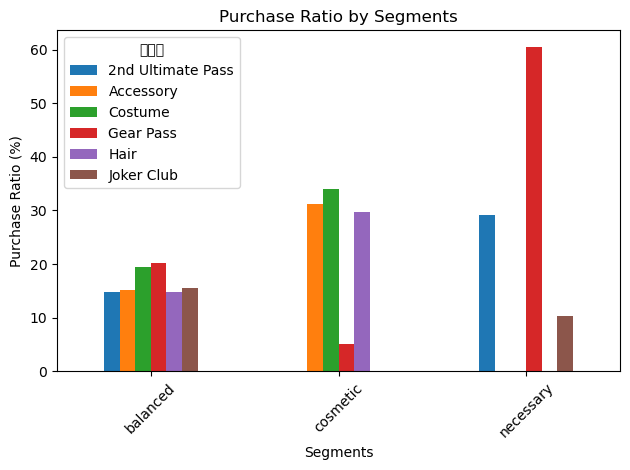


세그먼트별 유저당 평균 구매 횟수:
segment
balanced     6.0
cosmetic     3.9
necessary    2.8
Name: purchase_count, dtype: float64


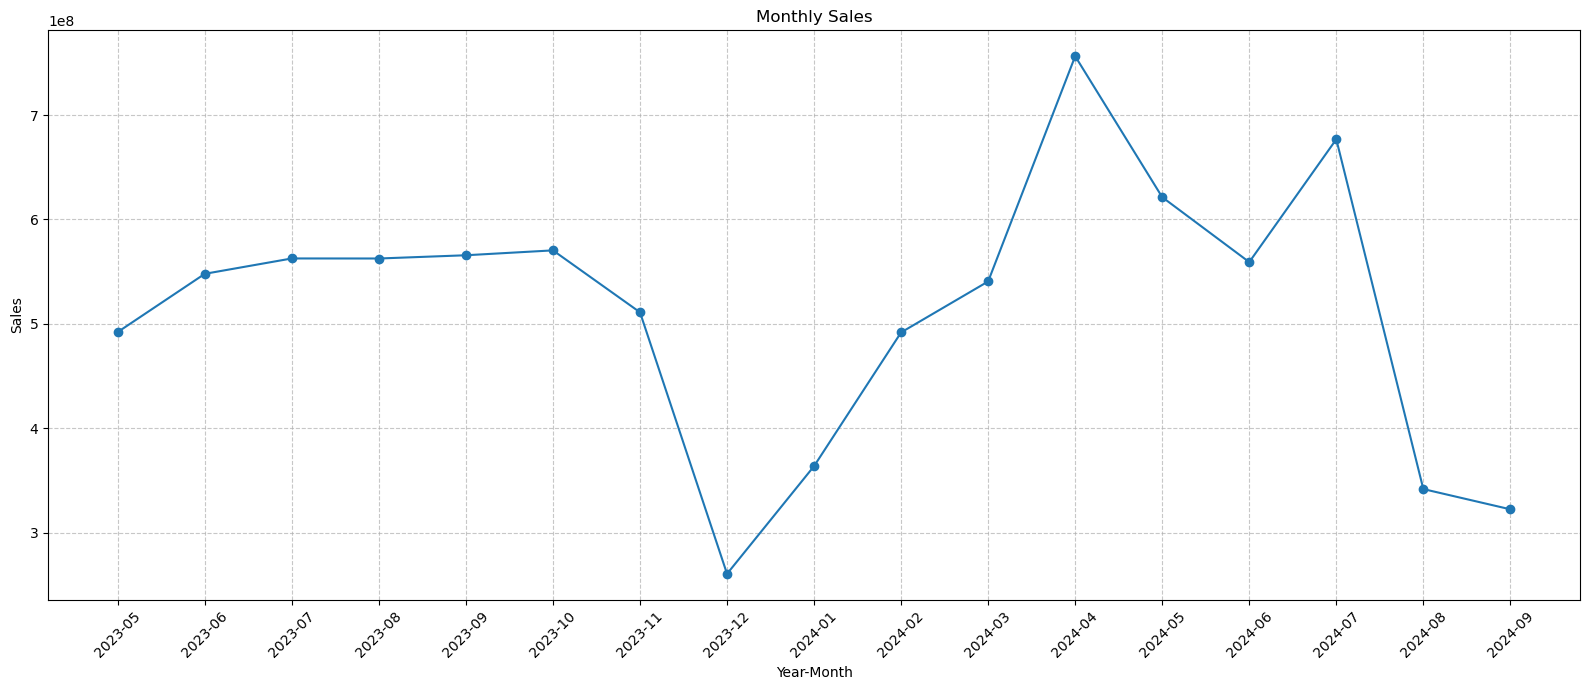

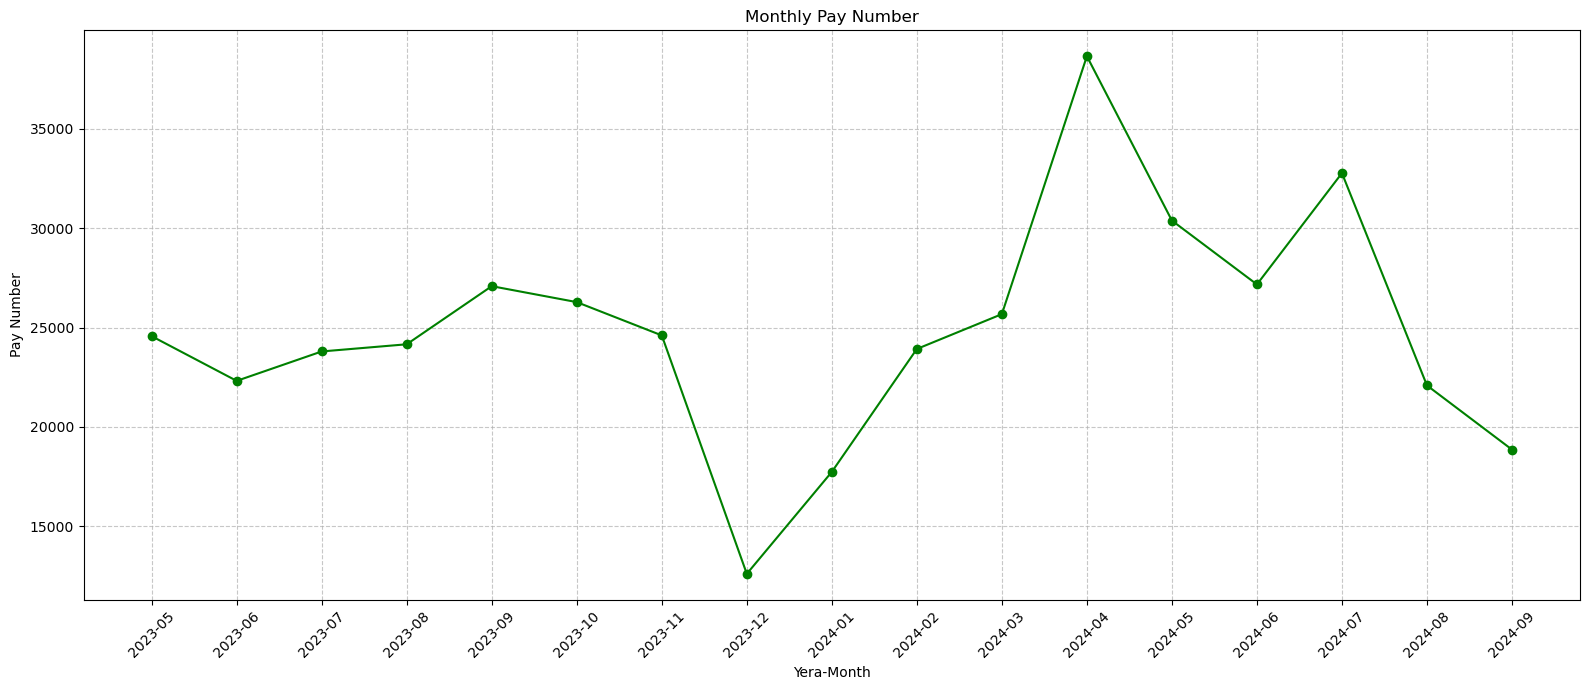

In [16]:
# 생성된 데이터 분석
segment_item_distribution, segment_purchase_freq = analyze_data(df)

## (2) 군집 결과 확인

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 사용자별 결제 금액과 구매 횟수 집계
user_spending = df.groupby("userid")["payamount"].sum().reset_index()
user_spending["total_spent"] = user_spending["payamount"]
user_purchases = df.groupby("userid")["payamount"].count().reset_index()
user_most_purchased_item = df.groupby("userid")["item"].agg(lambda x: x.value_counts().idxmax()).reset_index()

# 데이터 병합 및 컬럼명 정리
user_summary = user_spending.merge(user_purchases, on="userid")
user_summary = user_summary.merge(user_most_purchased_item, on="userid")
user_summary.columns = ["userid", "payamount", "total_spent", "purchase_count", "most_purchased_item"]

# 데이터 정규화
scaler = StandardScaler()
user_summary_scaled = scaler.fit_transform(user_summary[["total_spent", "purchase_count"]])

# 최적의 클러스터 개수 설정 (K=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
user_summary["cluster"] = kmeans.fit_predict(user_summary_scaled)

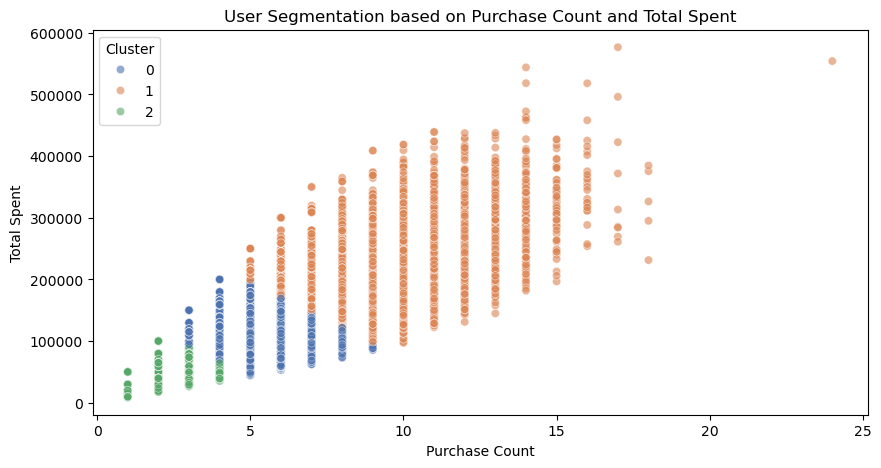

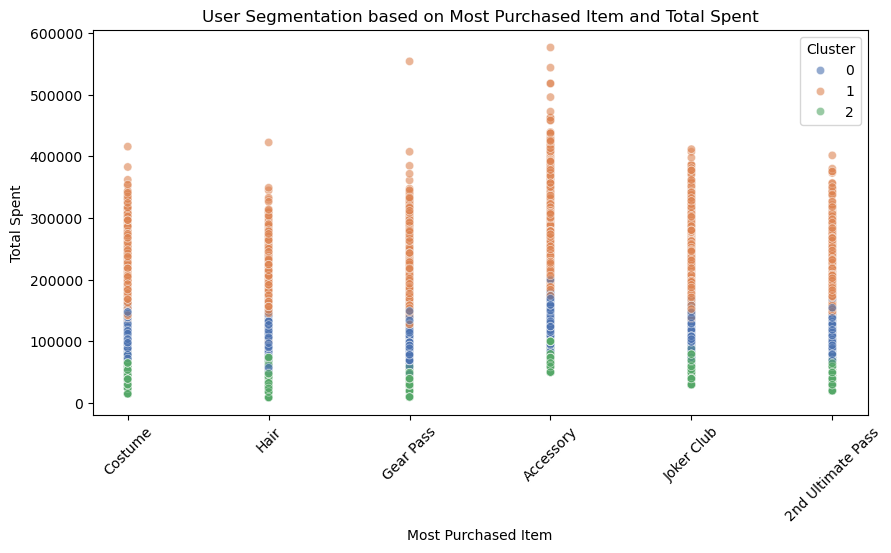

In [41]:
# 결과 시각화 1
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=user_summary["purchase_count"],
    y=user_summary["total_spent"],
    hue=user_summary["cluster"],
    palette="deep",
    alpha=0.6
)
plt.xlabel("Purchase Count")
plt.ylabel("Total Spent")
plt.title("User Segmentation based on Purchase Count and Total Spent")
plt.legend(title="Cluster")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=user_summary["most_purchased_item"],
    y=user_summary["total_spent"],
    hue=user_summary["cluster"],
    palette="deep",
    alpha=0.6
)
plt.xlabel("Most Purchased Item")
plt.ylabel("Total Spent")
plt.title("User Segmentation based on Most Purchased Item and Total Spent")
plt.legend(title="Cluster")
plt.xticks(rotation=45)
plt.show()

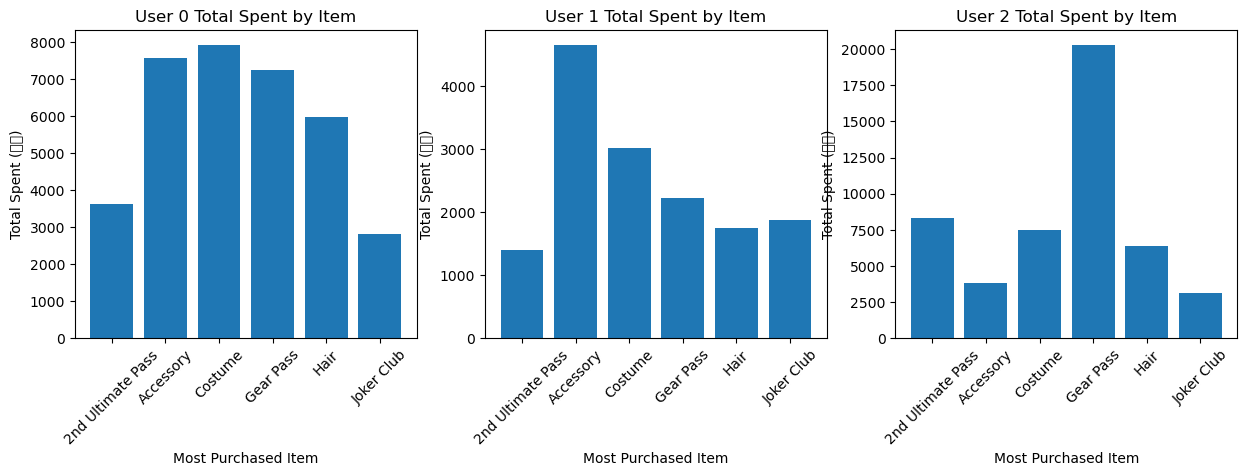

In [40]:
# 결과 시각화 2
user_0 = user_summary[user_summary['cluster'] == 0]
user_1 = user_summary[user_summary['cluster'] == 1]
user_2 = user_summary[user_summary['cluster'] == 2]

user_0_df = user_0.groupby('most_purchased_item').agg({
    'purchase_count' : 'count',
    'total_spent' : 'sum'
})
user_1_df = user_1.groupby('most_purchased_item').agg({
    'purchase_count' : 'count',
    'total_spent' : 'sum'
})
user_2_df = user_2.groupby('most_purchased_item').agg({
    'purchase_count' : 'count',
    'total_spent' : 'sum'
})

# Plot most purchased item vs total spent
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.bar(
    x=user_0_df.index,
    height=user_0_df["purchase_count"]
)
plt.xlabel("Most Purchased Item")
plt.ylabel("Total Spent (만원)")
plt.title("User 0 Total Spent by Item")
plt.xticks(rotation=45)

plt.subplot(1,3,2)
plt.bar(
    x=user_1_df.index,
    height=user_1_df["purchase_count"]
)
plt.xlabel("Most Purchased Item")
plt.ylabel("Total Spent (만원)")
plt.title("User 1 Total Spent by Item")
plt.xticks(rotation=45)

plt.subplot(1,3,3)
plt.bar(
    x=user_2_df.index,
    height=user_2_df["purchase_count"]
)
plt.xlabel("Most Purchased Item")
plt.ylabel("Total Spent (만원)")
plt.title("User 2 Total Spent by Item")
plt.xticks(rotation=45)

plt.show()